In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np

import scipy as scp
import sklearn
import sys, os, pickle

sys.path.append(os.path.join('..'))

from tradeoff.helper import *
from tradeoff.fairness import *
from tradeoff.data_util import *
from tradeoff.plot import *
from tradeoff.lin_opt import *

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
DATANAME='adult'
X_train, y_train, X_test, y_test, X_train_removed, X_test_removed, dtypes, dtypes_, sens_idc, race_idx, sex_idx = get_dataset(DATANAME)

In [5]:
try:
    grid_base =  pickle.load(open('model_adult_base.pkl', 'rb'))[0]
    grid =  pickle.load(open('model_adult.pkl', 'rb'))[0]
    model_base = grid_base.best_estimator_.named_steps['logisticregression']
    #model = grid.best_estimator_.named_steps['logisticregression']
    model = grid
except FileNotFoundError:
    model_names = ['LogisticRegression']
    result = create_and_train_models(model_names, dtypes_, X_train_removed, y_train, X_test=X_test_removed, y_test=y_test, save=True, data_name=DATANAME)
    result_base = create_and_train_models(model_names, dtypes, X_train, y_train, X_test=X_test, y_test=y_test, save=True, data_name=DATANAME + '_base')
    model_base = result_base[0]['estimator']
    model = result[0]['estimator']

In [6]:
model_names = ['LogisticRegression']
result = create_and_train_models(model_names, dtypes_, X_train_removed, y_train, X_test=X_test_removed, y_test=y_test, save=True, data_name=DATANAME)
model = result[0]['estimator']

Training {'model_name': 'LogisticRegression', 'estimator': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(categorical_features=array([False, False, False, False,  True,  True,  True,  True,  True,
        True]),
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values='auto', sparse=False)), ('standardscaler', StandardScaler(copy=True, with_me...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'logisticregression__C': array([0.0001, 0.1   ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0), 'get_model': <function create_model.<locals>.get_model at 0x7f6c80823d90>}


In [7]:
# Get fairness matrix information
fm = FairnessMeasures(X_train, 
                      y_train, 
                      X_test, 
                      y_test, 
                      X_train_removed, 
                      X_test_removed, 
                      model, 
                      sex_idx, 
                      pos_label=1, 
                      neg_label=0)

mats, mats_dict, M_const, b_const = get_fairness_mats(fm)

In [8]:
# Get csv file for eqodd code to run
get_csv_eqodd(fm, data_name=DATANAME)

In [9]:
# Run over multiple train-test splits
DATANAME='adult'
FAIRNESS_NAME='EqOdd'
no_trials = 10
seeds = np.array(range(no_trials)) + 42
eps_collection = np.zeros((100, no_trials))
acc_collection = np.zeros((100, no_trials))
for e, i in enumerate(seeds):
    X_train, y_train, X_test, y_test, X_train_removed, X_test_removed, dtypes, dtypes_, sens_idc, race_idx, sex_idx = get_dataset(DATANAME, seed=i, verbose=False)
    model = sklearn.linear_model.LogisticRegression(solver='lbfgs')
    model.fit(X_train_removed, y_train)
    fm = FairnessMeasures(X_train, 
                      y_train, 
                      X_test, 
                      y_test, 
                      X_train_removed, 
                      X_test_removed, 
                      model, 
                      sex_idx, 
                      pos_label=1, 
                      neg_label=0)
    _, eps_vals, acc_vals = plot_frontier(fm, FAIRNESS_NAME, plot=False)
    eps_collection[:, e] = eps_vals
    acc_collection[:, e] = acc_vals
mean_eps = np.mean(eps_collection, axis=1)
std_eps = np.std(eps_collection, axis=1)
mean_accs = np.mean(acc_collection, axis=1)
std_accs = np.std(acc_collection, axis=1)

In [10]:
## Some baseline models
X_train, y_train, X_test, y_test, X_train_removed, X_test_removed, dtypes, dtypes_, sens_idc, race_idx, sex_idx = get_dataset(DATANAME, seed=i)

# LR
lr = sklearn.linear_model.LogisticRegression(solver='lbfgs')
lr.fit(X_train_removed, y_train)
fm = FairnessMeasures(X_train, 
                      y_train, 
                      X_test, 
                      y_test, 
                      X_train_removed, 
                      X_test_removed, 
                      lr, 
                      sex_idx, 
                      pos_label=1, 
                      neg_label=0)
if FAIRNESS_NAME == 'EqOdd':
    a,b = fm.equalized_odds_diff()
    acc = fm.ACC
    lr_res = np.abs(a+b), acc
elif FAIRNESS_NAME == 'DemoParity':
    lr_res = (fm.group_parity_diff(), fm.ACC)
    
# SVM
svm = sklearn.svm.SVC()
svm.fit(X_train_removed, y_train)
fm = FairnessMeasures(X_train, 
                      y_train, 
                      X_test, 
                      y_test, 
                      X_train_removed, 
                      X_test_removed, 
                      svm, 
                      sex_idx, 
                      pos_label=1, 
                      neg_label=0)
if FAIRNESS_NAME == 'EqOdd':
    a,b = fm.equalized_odds_diff()
    acc = fm.ACC
    svm_res = np.abs(a+b), acc
elif FAIRNESS_NAME == 'DemoParity':
    svm_res = (fm.group_parity_diff(), fm.ACC)
    
# RF
rf = sklearn.ensemble.RandomForestClassifier()
rf.fit(X_train_removed, y_train)
fm = FairnessMeasures(X_train, 
                      y_train, 
                      X_test, 
                      y_test, 
                      X_train_removed, 
                      X_test_removed, 
                      rf, 
                      sex_idx, 
                      pos_label=1, 
                      neg_label=0)
if FAIRNESS_NAME == 'EqOdd':
    a,b = fm.equalized_odds_diff()
    acc = fm.ACC
    rf_res = np.abs(a+b), acc
elif FAIRNESS_NAME == 'DemoParity':
    rf_res = (fm.group_parity_diff(), fm.ACC)
    


In [11]:
# Read csv files for FGP results
from numpy import genfromtxt
if FAIRNESS_NAME == 'EqOdd':
    fgp_result = genfromtxt('eo_dist_fgp.csv', delimiter=',')
elif FAIRNESS_NAME == 'DemoParity':
    fgp_result = genfromtxt('sp_dist_fgp.csv', delimiter=',')

In [12]:
# Read csv files from EqODD results
if FAIRNESS_NAME == 'EqOdd':
    eqodd_result = genfromtxt('eqodd_result.csv', delimiter=',')

In [13]:
# Read csv files from Opt results
op_result = genfromtxt('op_result.csv', delimiter=',')

In [14]:
# Some only-fair-but-trivial-classifier

## constant prediction
const_pos = ConstEstimator(pos=True)
const_neg = ConstEstimator(pos=False)
fm_pos = FairnessMeasures(X_train, 
                      y_train, 
                      X_test, 
                      y_test, 
                      X_train_removed, 
                      X_test_removed, 
                      const_pos, 
                      sex_idx, 
                      pos_label=1, 
                      neg_label=0)
fm_neg = FairnessMeasures(X_train, 
                      y_train, 
                      X_test, 
                      y_test, 
                      X_train_removed, 
                      X_test_removed, 
                      const_neg, 
                      sex_idx, 
                      pos_label=1, 
                      neg_label=0)
if FAIRNESS_NAME == 'EqOdd':
    a,b = fm_pos.equalized_odds_diff()
    acc = fm_pos.ACC
    const_pos_res = np.abs(a+b), acc
    a,b = fm_neg.equalized_odds_diff()
    acc = fm_neg.ACC
    const_neg_res = 1e-6, acc
elif FAIRNESS_NAME == 'DemoParity':
    const_pos_res = (fm_pos.group_parity_diff(), fm_pos.ACC)
    const_neg_res = (fm_neg.group_parity_diff(), fm_neg.ACC)    


In [15]:
rand_clf = RandomEstimator(seed=5)
fm_rand = FairnessMeasures(X_train, 
                          y_train, 
                          X_test, 
                          y_test, 
                          X_train_removed, 
                          X_test_removed, 
                          const_pos, 
                          sex_idx, 
                          pos_label=1, 
                          neg_label=0)
if FAIRNESS_NAME == 'EqOdd':
    a,b = fm_rand.equalized_odds_diff()
    acc = fm_rand.ACC
    rand_res = np.abs(a+b), acc
elif FAIRNESS_NAME == 'DemoParity':
    rand_res = (fm_rand.group_parity_diff(), fm_rand.ACC)

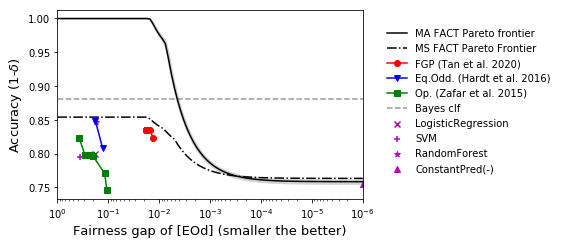

In [17]:
f, axs = plt.subplots(figsize=(8,3.5))

upper = mean_accs + std_accs
upper[upper >= 1.0] = 1.0

SCALE = 0
axs.semilogx(mean_eps, mean_accs-SCALE, color='k', linestyle='-', label='MA FACT Pareto frontier')
plt.fill_between(mean_eps, upper-SCALE, mean_accs-std_accs-SCALE, color='lightgrey')

### post processing
import pickle
## NOTE: this file can be obtained by first running the post-process.ipynb notebook.
pp = pickle.load(open('postprocess.pkl', 'rb'))
axs.plot(pp[0], pp[1], 'k-.', label='MS FACT Pareto Frontier')

# Plot other methods

# plot FGP (Tan et al. 2019)
axs.semilogx(fgp_result[:,0], fgp_result[:,1], color='r', label='FGP (Tan et al. 2020)', linestyle='-', marker='o' )

# plot EqOdds (Hardt et al. 2016)
axs.semilogx(eqodd_result[:,0], eqodd_result[:,1], color='b', label='Eq.Odd. (Hardt et al. 2016)', linestyle='-', marker='v')

# plot Optimization-based (Zafar et al. 2015)
axs.semilogx(op_result[:,0], op_result[:,1], color='g', label='Op. (Zafar et al. 2015)', linestyle='-', marker='s')

# Plot baseline models
axs.scatter(lr_res[0], lr_res[1], label='LogisticRegression', color='m', marker='x')
axs.scatter(svm_res[0], svm_res[1], label='SVM', color='m', marker='+')
axs.scatter(rf_res[0], rf_res[1], label='RandomForest', color='m', marker='*')

# Plot const model
axs.scatter(const_neg_res[0], const_neg_res[1], label='ConstantPred(-)', color='m', marker='^')


xmax, xmin = axs.get_xlim()
axs.set_xlim(1e-6)
BAYES = 0.88
axs.plot([xmin, 1e-6], [BAYES, BAYES], color='k', linestyle='--', alpha=0.4, label='Bayes clf')

axs.invert_xaxis()

axs.set_xlim(1, 0)
axs.set_ylabel('Accuracy (1-$\delta$)', fontsize=13)
axs.set_xlabel('Fairness gap of [EOd] (smaller the better)', fontsize=13)

axs.set_aspect('equal', 'box')
plt.legend(bbox_to_anchor=(1.05, 0.95), frameon=False)
#axs.legend(loc='top right', frameon=False)
plt.tight_layout()
plt.savefig('frontier.pdf', dpi=300)